In [1]:
"""All required modules"""
!pip install torch-geometric
!pip install hiddenlayer
import hiddenlayer as hl
from numpy import loadtxt
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import joblib
import time
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [3]:
#installing drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#positions = np.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt') #load datasets
winners = pd.read_csv("/content/drive/MyDrive/My_stratego_project/files/Y_winners_encoded.csv", header = None)
positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_strategies_and_positions.txt')
#positions = np.array(positions).reshape(99132, 40, 12) #Reshaping the data to a 40 by 12 matrix

In [5]:
"""Changes the one hot encoding to a row hot encoding and normalized"""
#positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_strategies_and_positions_normalized.txt') #comment out if you want to use the one-hot encoding instead


'Changes the one hot encoding to a row hot encoding and normalized'

In [6]:
np.array(positions).shape

(99130, 40, 17)

In [7]:
"""for -1 to 1 classification, changes winner variable to -1 and 1, comment out to use 0/1 classification"""
winners_new = []
i=0
for winner in winners[0]:
  if winner == 0:
    winners_new.append(winner-1)
  else:
    winners_new.append(winner)
  i+=1

In [8]:
"""Creates 4 edge indeces based on the sizes created after the sagpooling operation, they're all square boards"""

##Possible imporvement to be added is to create edge index based on removed and included nodes after the sagpooling operation
def edge_index(row,column):
  """Creates a edge index based on a number of rows and columns as input"""
  edge_index = []
  for row in range(num_rows):
      for col in range(num_cols):
          node_idx = row * num_cols + col

          if row > 0:  #connect to top neighbor
              top_neighbor_idx = (row - 1) * num_cols + col
              edge_index.append([node_idx, top_neighbor_idx])

          if row < num_rows - 1:  #connect to bottom neighbor
              bottom_neighbor_idx = (row + 1) * num_cols + col
              edge_index.append([node_idx, bottom_neighbor_idx])

          if col > 0:  #connect to left neighbor
              left_neighbor_idx = row * num_cols + (col - 1)
              edge_index.append([node_idx, left_neighbor_idx])

          if col < num_cols - 1:  #connect to right neighbor
              right_neighbor_idx = row * num_cols + (col + 1)
              edge_index.append([node_idx, right_neighbor_idx])

  return torch.tensor(edge_index).t().contiguous()

num_rows = 4
num_cols = 10
edge_index1 = edge_index(num_rows , num_cols)#(4,10)

num_rows = 3
num_cols = 10
edge_index2 = edge_index(num_rows , num_cols)#(3,10)

num_rows = 2
num_cols = 10
edge_index3 = edge_index(num_rows , num_cols)#(2,10)

num_rows = 2
num_cols = 5
edge_index4 = edge_index(num_rows , num_cols)#(2,5)


In [9]:
edge_index4.shape

torch.Size([2, 26])

In [10]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        #if the elements of the batch are Data objects,
        #return a list of Data objects
        return batch


In [11]:

#defines a train test split with 0.2 test data
train_dataset, test_dataset = train_test_split(positions, test_size=0.2, random_state=42)


In [12]:
matches_dataset = list()
i=-1
for game in train_dataset:#creates a dataloader object with batches of size 503 for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(game), edge_index=edge_index1, y=torch.tensor(winners_new[i])))
matches_loader_12_features_training = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

matches_dataset = list()
i=-1
for game in test_dataset:#creates a dataloader object with batches of size 503 for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(game), edge_index=edge_index1, y=torch.tensor(winners_new[i])))
matches_loader_12_features_test = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

In [13]:
matches_dataset = list()
i=-1
for game in train_dataset:#creates a dataloader object with batches of size 503, dummy features for training data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(np.argmax(game, axis=1)).reshape(40,1), edge_index=edge_index1, y=torch.tensor(winners_new[i])))

matches_loader_1dummy_training = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)


matches_dataset = list()
i=-1
for game in test_dataset:#creates a dataloader object with batches of size 503, dummy features for test data
  i+=1
  matches_dataset.append(Data(x=torch.tensor(np.argmax(game, axis=1)).reshape(40,1), edge_index=edge_index1, y=torch.tensor(winners_new[i])))

matches_loader_1dummy_test = DataLoader(matches_dataset, batch_size=751, collate_fn=custom_collate, shuffle=False)

In [14]:
len(matches_loader_12_features_training.dataset)

79304

In [15]:
len(matches_loader_12_features_test.dataset)

19826

In [16]:
one_hot_features = np.argmax(positions[0], axis=1).reshape(4, 10, order='F')


In [17]:

#active_indices = np.argmax(positions[0], axis=2)
#active_indices = torch.tensor(active_indices)

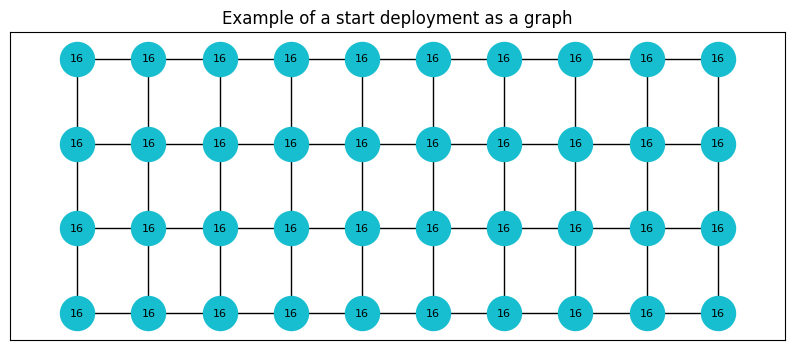

<Figure size 640x480 with 0 Axes>

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

"""If you want to run and visualize a deployment as a graph please run the code without the added encoded strategies"""


# Generate a 4x10 grid graph
G = nx.grid_2d_graph(4, 10)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 4))
ax = plt.gca()

# Generate node positions for a 4x10 grid
pos = {(x, y): (y, -x) for x in range(4) for y in range(10)}

one_hot_features = np.argmax(positions[0], axis=1).reshape(4, 10, order='F')

# Iterate over the nodes and assign labels and colors
for (x, y) in G.nodes():
    # Find the index of the active feature
    active_feature_index = one_hot_features[x, y]

    # Assign label and color based on the active feature index
    label = str(active_feature_index)
    color = plt.cm.tab10(active_feature_index)  # Use a color map for coloring nodes

    # Draw the node with the assigned label and color
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[(x, y)], node_color=[color], node_size=600, ax=ax)
    nx.draw_networkx_labels(G, pos=pos, labels={(x, y): label}, font_color='black', font_size=8, ax=ax)

# Draw the edges of the graph
nx.draw_networkx_edges(G, pos=pos, ax=ax)

# Set plot title
plt.title('Example of a start deployment as a graph')

# Show the plot
plt.show()
plt.savefig('grid_graph.png')

In [19]:
from torch_geometric.nn import SAGPooling
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv, SAGEConv
from torch_geometric.nn import global_mean_pool

class SimpleGNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleGNN, self).__init__()

        self.conv1 = GCNConv(input_dim, input_dim)
        #self.conv2 = GCNConv(input_dim, input_dim)
        self.conv3 = GCNConv(input_dim, input_dim)
        self.conv4 = GCNConv(input_dim, 1)

        self.tanh = nn.Tanh()
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.tanh(x)
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.conv4(x, edge_index)
        x = self.tanh(x)
        x = torch.sum(x)


        return x

In [20]:
edge_index1

tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,
          6,  6,  7,  7,  7,  8,  8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 11, 12,
         12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
         16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21,
         21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26,
         26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 30, 30, 31, 31,
         31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37,
         37, 38, 38, 38, 39, 39],
        [10,  1, 11,  0,  2, 12,  1,  3, 13,  2,  4, 14,  3,  5, 15,  4,  6, 16,
          5,  7, 17,  6,  8, 18,  7,  9, 19,  8,  0, 20, 11,  1, 21, 10, 12,  2,
         22, 11, 13,  3, 23, 12, 14,  4, 24, 13, 15,  5, 25, 14, 16,  6, 26, 15,
         17,  7, 27, 16, 18,  8, 28, 17, 19,  9, 29, 18, 10, 30, 21, 11, 31, 20,
         22, 12, 32, 21, 23, 13, 33, 22, 24, 14, 34, 23, 25, 15, 35, 24, 26

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define train and test set
matches_loader_12_features_training
matches_loader_12_features_test
#define record keeping
batch_loss = 0
epoch_losses =[]
batch_losses=[]
#2.Instantiate the Model
input_size = 17  #Assuming each node has 17 features(includes encoded strategies otherwise 12)

model = SimpleGNN(input_size,1).to(device)


#3.Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)


#4.Training Loop

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    start_epoch_time = time.time() # Record start time of epoch

    for batch_idx, batch in enumerate(matches_loader_12_features_training):
        start_batch_time = time.time() # Record start time of batch
        data_idx = 0
        batch_output = torch.tensor([]).to(device)
        batch_y = []
        total_batch_loss = 0

        for data in range(len(batch)):
            optimizer.zero_grad()

            x, y, edge_index = batch[data_idx].x.float().to(device), batch[data_idx].y.to(device), batch[data_idx].edge_index.to(device)
            output = model(x, edge_index)
            if batch_output.numel() == 0:
                batch_output = output.unsqueeze(0)
            else:
                batch_output = torch.cat((batch_output, output.unsqueeze(0)), dim=0)
            batch_y.append(y)
            data_idx += 1
        loss = criterion(batch_output, torch.tensor(batch_y).to(device))
        loss.backward()
        optimizer.step()
        total_batch_loss += loss

        end_batch_time = time.time() # Record end time of batch

        # Calculate average loss for this batch
        avg_batch_loss = total_batch_loss
        batch_losses.append(avg_batch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(matches_loader_12_features_training)}], "
              f"Time: {end_batch_time - start_batch_time:.4f} sec, Avg Batch Loss: {avg_batch_loss:.6f}")

    end_epoch_time = time.time() # Record end time of epoch
    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(avg_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Epoch Loss: {avg_epoch_loss:.6f}, "
          f"Epoch Time: {end_epoch_time - start_epoch_time:.4f} sec")


Epoch [1/3], Batch [1/106], Time: 2.5632 sec, Avg Batch Loss: 1041.872681
Epoch [1/3], Batch [2/106], Time: 2.5397 sec, Avg Batch Loss: 998.264465
Epoch [1/3], Batch [3/106], Time: 2.5438 sec, Avg Batch Loss: 953.395569
Epoch [1/3], Batch [4/106], Time: 2.8711 sec, Avg Batch Loss: 886.931152
Epoch [1/3], Batch [5/106], Time: 3.5898 sec, Avg Batch Loss: 858.979553
Epoch [1/3], Batch [6/106], Time: 2.5306 sec, Avg Batch Loss: 799.412048
Epoch [1/3], Batch [7/106], Time: 2.5228 sec, Avg Batch Loss: 703.598206
Epoch [1/3], Batch [8/106], Time: 2.5335 sec, Avg Batch Loss: 657.532471
Epoch [1/3], Batch [9/106], Time: 2.7010 sec, Avg Batch Loss: 585.192505
Epoch [1/3], Batch [10/106], Time: 3.6078 sec, Avg Batch Loss: 544.226135
Epoch [1/3], Batch [11/106], Time: 2.7826 sec, Avg Batch Loss: 481.711578
Epoch [1/3], Batch [12/106], Time: 2.5565 sec, Avg Batch Loss: 413.570038
Epoch [1/3], Batch [13/106], Time: 2.4885 sec, Avg Batch Loss: 379.741547
Epoch [1/3], Batch [14/106], Time: 2.5597 sec,

In [22]:
batch_output, batch.y

(tensor([-3.0138e+00,  1.7168e+00, -1.3955e+00, -3.0719e+00,  1.8097e+00,
         -8.6072e-01, -9.9161e-01,  1.0886e+00,  3.5236e+00,  5.6255e-02,
         -1.4732e-01, -3.2812e+00,  1.2316e+00,  2.3029e+00,  1.1089e+00,
         -2.7753e+00, -2.6639e-01, -1.0636e+00,  1.7093e-01, -7.4467e-01,
         -4.1101e+00,  2.1324e+00, -2.8620e+00, -3.8791e+00, -3.4049e+00,
         -1.6221e+00, -3.6716e-02,  2.3916e+00,  3.8958e-01, -3.7243e+00,
         -3.6948e+00,  4.1141e-02,  2.5221e+00,  4.0347e-01,  2.9397e+00,
          1.1438e+00, -3.3619e+00, -1.0001e-01,  1.8388e+00, -1.4826e+00,
          1.3454e+00,  2.1109e+00, -2.2167e+00, -1.4000e+00,  6.9979e-01,
          8.2395e-02,  4.6609e+00, -8.8425e-01, -3.9558e+00,  3.3902e+00,
         -4.7657e-01, -3.2256e+00,  3.7705e+00, -9.0770e-01,  1.2063e+00,
         -8.3070e-01,  6.5307e-01,  1.1643e+00,  3.2441e+00,  2.8842e-01,
          2.1922e+00, -1.2617e+00,  2.9930e+00,  3.1401e+00, -3.3361e+00,
         -1.2698e+00,  5.2770e-01, -1.

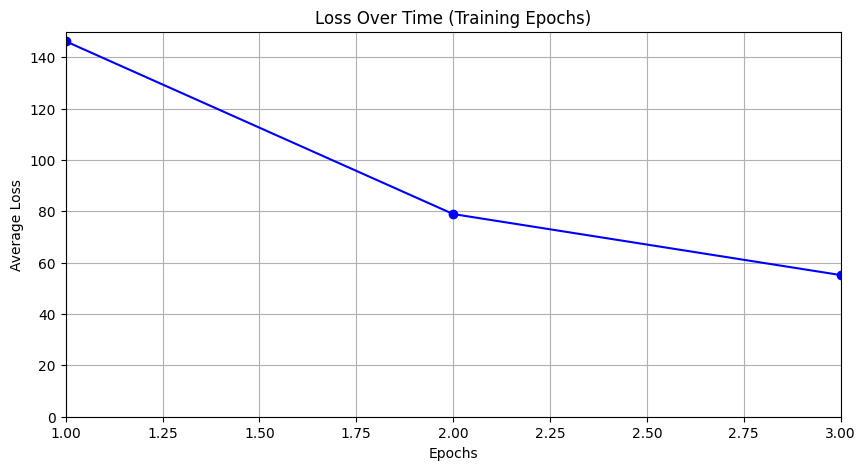

In [23]:
import matplotlib.pyplot as plt


#remove gradients from tensor list
ep_loss_list = []
for loss in epoch_losses:
  ep_loss_list.append(loss.cpu().detach().numpy())

# Loss Over Time (Training Epochs)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), ep_loss_list, marker='o', color='b')
plt.title('Loss Over Time (Training Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xlim(1, num_epochs)  # Set x limits
plt.ylim(0, 150)  # Set y limits
plt.show()


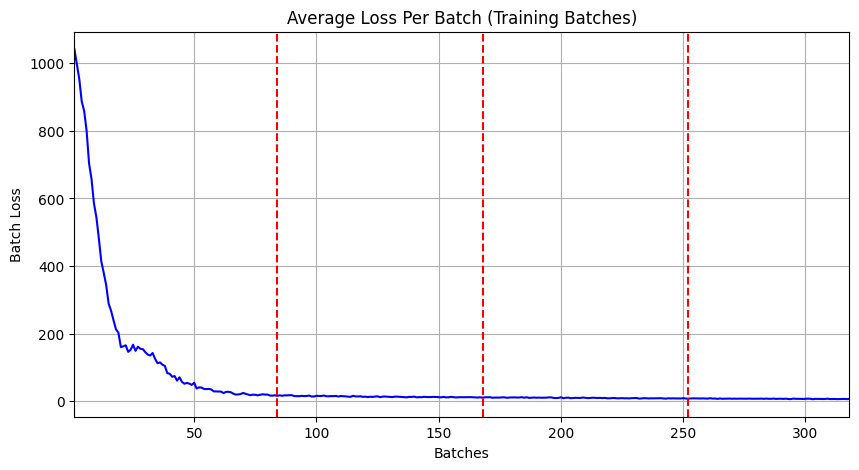

In [24]:
#remove gradients from tensor list
batch_loss_list = []
for loss in batch_losses:
  batch_loss_list.append(loss.cpu().detach().numpy())



# Loss Per Batch (Training Batches)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(batch_loss_list)+1), batch_loss_list, color='b')
plt.title('Average Loss Per Batch (Training Batches)')
plt.xlabel('Batches')
plt.ylabel('Batch Loss')
plt.grid(True)
plt.xlim(1, len(batch_loss_list))  # Set x limits

for batch_idx in range(1, len(batch_loss_list)+1):
    if batch_idx % 84 == 0:
        plt.axvline(x=batch_idx, color='r', linestyle='--')

plt.show()


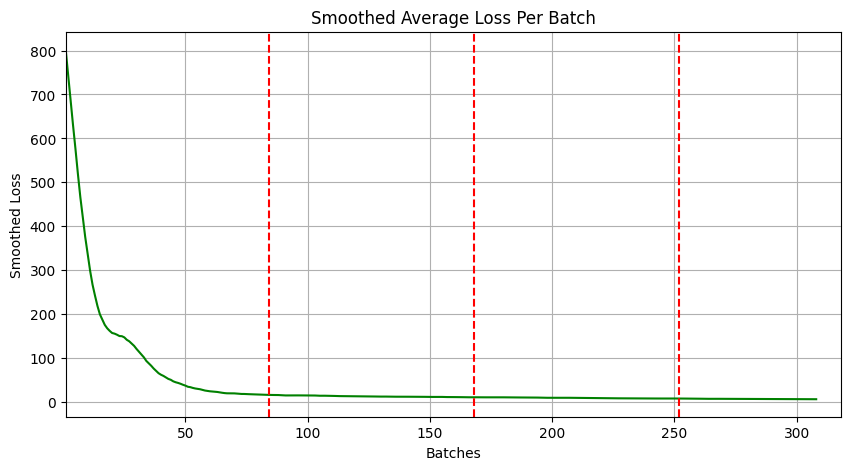

In [25]:
# Smoothed Loss Per Batch
smoothed_losses = [sum(batch_loss_list[i:i+10])/10 for i in range(len(batch_loss_list)-10)]
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smoothed_losses)+1), smoothed_losses, color='g')
plt.title('Smoothed Average Loss Per Batch')
plt.xlabel('Batches')
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.xlim(1, len(batch_loss_list))  # Set x limits
for batch_idx in range(1, len(batch_loss_list)+1):
    if batch_idx % 84 == 0:
        plt.axvline(x=batch_idx, color='r', linestyle='--')

plt.show()

In [26]:

# Assuming you have already instantiated your model and trained it
# model = SimpleGNN(input_size, hidden_channels, 1)
# (train your model...)

# Get the weights from the WeightedSumLayer
#weights = model.weightedsum.weights.cpu().detach().numpy()

# Reshape the weights into a 4x10 matrix
#weights_reshaped = weights.reshape((4, 10))

# Create the heatmap
#plt.figure(figsize=(10, 4))
#plt.imshow(weights_reshaped, cmap='viridis', aspect='auto')

# Add title and labels
#plt.title('Node Weights')
#plt.xlabel('Columns')
#plt.ylabel('Rows')

# Add colorbar
#plt.colorbar()
#plt.grid(True)
#plt.xticks(np.arange(10), np.arange(1, 11))  # Set x-axis ticks and labels
#plt.yticks(np.arange(4), np.arange(1, 5))    # Set y-axis ticks and labels


# Show the plot
#plt.show()


In [27]:
# 5. Evaluation
"""MSE calculation"""
#set to model eval mode
model.eval()

#record keeping
correct = 0
total_loss = 0
total = 0
total_batches = len(matches_loader_12_features_test)
average_MSE = 0
average_MSE_list = []
total_MSE_avg = []
total_MSE = 0


start_time = time.time()  #record start time

with torch.no_grad():
    for batch_idx, batch in enumerate(matches_loader_12_features_test):
        iteration = 0  # index for element in batch
        batch_correct = 0
        batch_total = 0
        batch_error = 0
        for data in range(len(batch)):
            x, y, edge_index = batch[iteration].x.float(), batch[iteration].y.float(), batch[iteration].edge_index  # Extract node features, edge index, and target labels

            output = model(x, edge_index)
            total_loss += criterion(output, y).item()
            error = (y-output)**2
            batch_error += error
            batch_total += 1
            total += 1
        total_MSE += batch_error
        avg_batch_MSE = batch_error / batch_total
        average_MSE_list.append(avg_batch_MSE)

        print(f'Batch {batch_idx + 1}/{total_batches}, MSE: {avg_batch_MSE.item():.2f}')

# Compute overall MSE
MSE_avg = sum(average_MSE_list) / 21 #21 is number of batches in test set
end_time = time.time()  # Record end time
total_time = end_time - start_time
print(f'Total Time taken: {total_time:.2f} seconds')
print(f'Validation MSE: {float(total_MSE):.2f}')
print(f'Average MSE per Batch: {MSE_avg.float().item():.2f}')



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch 1/27, MSE: 1.43
Batch 2/27, MSE: 2.05
Batch 3/27, MSE: 0.31
Batch 4/27, MSE: 2.50
Batch 5/27, MSE: 3.93
Batch 6/27, MSE: 1.95
Batch 7/27, MSE: 4.52
Batch 8/27, MSE: 2.09
Batch 9/27, MSE: 7.91
Batch 10/27, MSE: 2.03
Batch 11/27, MSE: 4.28
Batch 12/27, MSE: 0.50
Batch 13/27, MSE: 4.95
Batch 14/27, MSE: 5.17
Batch 15/27, MSE: 0.05
Batch 16/27, MSE: 2.06
Batch 17/27, MSE: 0.10
Batch 18/27, MSE: 0.06
Batch 19/27, MSE: 5.07
Batch 20/27, MSE: 4.02
Batch 21/27, MSE: 3.03
Batch 22/27, MSE: 0.32
Batch 23/27, MSE: 3.57
Batch 24/27, MSE: 0.51
Batch 25/27, MSE: 5.40
Batch 26/27, MSE: 0.02
Batch 27/27, MSE: 7.32
Total Time taken: 56.52 seconds
Validation MSE: 53141.76
Average MSE per Batch: 3.58


In [28]:
output

tensor(-1.7056)

In [29]:
# 5. Evaluation set to accuracy calculation instead of MSE
"""Accuracy calculation"""
#set to model eval mode
model.eval()

#record keeping
correct = 0
total_loss = 0
total = 0
total_batches = len(matches_loader_12_features_test)
average_MSE = 0
batch_accuracy_list = []
total_MSE_avg = []
total_correct = 0
accuracy = 0

start_time = time.time()  #record start time

with torch.no_grad():
    for batch_idx, batch in enumerate(matches_loader_12_features_test):
        iteration = -1  # index for element in batch
        batch_total = 0
        batch_accuracy = 0
        correct = 0
        for data in range(len(batch)):
            iteration+=1
            x, y, edge_index = batch[iteration].x.float(), batch[iteration].y.float(), batch[iteration].edge_index  # Extract node features, edge index, and target labels

            output = model(x, edge_index)
            total_loss += criterion(output, y).item()


            if (output.float()>=0) and y==1:
              correct += 1
            elif (output.float()<0) and y==-1:
              correct += 1
            else:
              correct += 0


            batch_total += 1
            total += 1
        batch_accuracy = correct / batch_total
        batch_accuracy_list.append(batch_accuracy)
        total_correct += correct
        print(f'Batch {batch_idx + 1}/{total_batches}, Accuracy: {batch_accuracy:.2f}')

# Compute overall accuracy
accuracy_avg = total_correct / len(matches_loader_12_features_test.dataset) #21 is number of batches in test set
end_time = time.time()  # Record end time
total_time = end_time - start_time
print(f'Total Time taken: {total_time:.2f} seconds')
print(f'Validation correct predictions: {float(total_correct):.2f}')
print(f'Average accuracy per batch: {accuracy_avg:.4f}')



Batch 1/27, Accuracy: 0.50
Batch 2/27, Accuracy: 0.48
Batch 3/27, Accuracy: 0.50
Batch 4/27, Accuracy: 0.48
Batch 5/27, Accuracy: 0.47
Batch 6/27, Accuracy: 0.52
Batch 7/27, Accuracy: 0.52
Batch 8/27, Accuracy: 0.49
Batch 9/27, Accuracy: 0.50
Batch 10/27, Accuracy: 0.49
Batch 11/27, Accuracy: 0.50
Batch 12/27, Accuracy: 0.51
Batch 13/27, Accuracy: 0.49
Batch 14/27, Accuracy: 0.50
Batch 15/27, Accuracy: 0.50
Batch 16/27, Accuracy: 0.50
Batch 17/27, Accuracy: 0.52
Batch 18/27, Accuracy: 0.52
Batch 19/27, Accuracy: 0.49
Batch 20/27, Accuracy: 0.50
Batch 21/27, Accuracy: 0.51
Batch 22/27, Accuracy: 0.51
Batch 23/27, Accuracy: 0.48
Batch 24/27, Accuracy: 0.52
Batch 25/27, Accuracy: 0.50
Batch 26/27, Accuracy: 0.54
Batch 27/27, Accuracy: 0.50
Total Time taken: 59.39 seconds
Validation correct predictions: 9938.00
Average accuracy per batch: 0.5013


In [30]:
""""Please download this file and upload it to the files folder in the project"""
""""You need this file to run the 'testing of different positions' notebook"""
torch.save(model.state_dict(), 'GCNmodelCPUHinge.pth') #saves model parameters

In [31]:
#2nd phase include creation of own data with minor changes and check how the model responds to it
#This is done in Position_effects_on_model_predictions.ipynb